In [1]:
from qiskit.algorithms.optimizers import COBYLA,CG
from qiskit.algorithms import NumPyMinimumEigensolver, VQE,QAOA
from qiskit.opflow import PauliExpectation, CVaRExpectation
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import LinearEqualityToPenalty
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.translators import from_docplex_mp
from qiskit import execute, Aer
from qiskit.utils import algorithm_globals

import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model

In [2]:
# !pip install --upgrade qiskit

In [3]:
# !pip install --upgrade qiskit-optimization

In [4]:
import qiskit_optimization

In [5]:
qiskit_optimization.__version__

'0.4.0'

In [6]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.21.0', 'qiskit-aer': '0.10.4', 'qiskit-ignis': '0.7.0', 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.37.0', 'qiskit-nature': None, 'qiskit-finance': '0.3.3', 'qiskit-optimization': '0.4.0', 'qiskit-machine-learning': '0.4.0'}

## Reading the data extracted from Yahoo finance for 10 assets ##

In [7]:
import pandas as pd

In [8]:
yahoo_finance_data = pd.read_excel('yahoo_finance_data.xlsx')

In [9]:
yahoo_finance_data.head(20)

,Date,Price,Returns,ONGC,TATASTEEL,HINDALCO,ICICI,BRITANNIA,ULTRATECH,WIPRO,APOLO,JUBLFOODS
0,2022-05-18,7517.057617,-0.021410,-0.019608,-0.049227,-0.043797,-0.024104,-0.018354,-0.025851,-0.062545,-0.027630,-0.016838
1,2022-05-19,7356.117188,0.024586,0.011875,0.043176,0.029017,0.027886,0.035474,0.009230,0.018730,0.009967,0.012144
2,2022-05-20,7536.977051,0.040974,-0.042001,-0.126132,-0.037171,0.002114,0.010666,-0.034649,0.013925,0.013345,-0.004410
3,2022-05-23,7845.793945,-0.012004,-0.028691,-0.016228,-0.029892,-0.004078,-0.004760,-0.008155,-0.012983,-0.022949,-0.014936
4,2022-05-24,7751.613770,-0.001974,0.012944,-0.007204,-0.009855,0.007343,0.013269,-0.012926,-0.032830,-0.029560,-0.028652
5,2022-05-25,7736.314453,0.002279,-0.004587,0.052948,0.027718,0.021238,0.012640,0.014166,0.019108,0.039299,0.048229
6,2022-05-26,7753.948242,0.017675,-0.053324,-0.008080,0.003187,0.015511,-0.000941,0.012555,0.029999,0.054316,0.061415
7,2022-05-27,7890.996094,0.008932,0.001738,0.003785,0.018575,0.011760,0.005242,0.026000,0.019916,0.007820,0.096952
8,2022-05-30,7961.481934,-0.005933,0.049983,0.007828,0.013917,0.005812,0.020007,-0.003285,0.003780,0.022444,-0.028050
9,2022-05-31,7914.243164,-0.003383,-0.009917,0.007484,-0.028162,-0.000266,-0.026454,-0.017583,-0.015270,-0.035257,0.009166


In [10]:
len(yahoo_finance_data)

64

In [11]:
yahoo_finance_data.drop(columns=['Price'],inplace=True)

In [12]:
yahoo_finance_data = yahoo_finance_data.rename(columns={'Returns':'Maruti'})

# Experiment with 10 assets #

## We extracted data for 10 assets from Yahoo Finance, time period: 1 quarter, found the means and the covariance matrix for this data ##

In [13]:
# yahoo_finance_data.sample(20)

In [14]:
yahoo_finance_data.set_index('Date',inplace=True)

In [15]:
cov_df=yahoo_finance_data.cov()

In [16]:
cov_df.to_numpy().shape

(10, 10)

In [17]:
sigma = cov_df.to_numpy()

In [18]:
sigma

array([[0.01596443, 0.01568142, 0.01582179, 0.01573338, 0.01576616,
        0.01577389, 0.01575688, 0.01574434, 0.01580112, 0.01585312],
       [0.01568142, 0.01652199, 0.01542503, 0.01597585, 0.01572152,
        0.01547838, 0.01564724, 0.01564234, 0.01553762, 0.01546644],
       [0.01582179, 0.01542503, 0.03272758, 0.015456  , 0.01585223,
        0.0159381 , 0.01560434, 0.01541476, 0.01568719, 0.01557992],
       [0.01573338, 0.01597585, 0.015456  , 0.01634575, 0.01588138,
        0.01571518, 0.01580981, 0.01588733, 0.01581064, 0.01585341],
       [0.01576616, 0.01572152, 0.01585223, 0.01588138, 0.01591485,
        0.01576412, 0.01579542, 0.01579451, 0.01579423, 0.01586452],
       [0.01577389, 0.01547838, 0.0159381 , 0.01571518, 0.01576412,
        0.01591779, 0.01574653, 0.01571657, 0.0157756 , 0.01582377],
       [0.01575688, 0.01564724, 0.01560434, 0.01580981, 0.01579542,
        0.01574653, 0.01595813, 0.01576214, 0.01575905, 0.01588286],
       [0.01574434, 0.01564234, 0.0154147

In [19]:
# yahoo_finance_data.corr()

In [20]:
mu=yahoo_finance_data.mean().to_numpy()

In [21]:
mu

array([-0.01278393, -0.01757157,  0.00153725, -0.01503446, -0.01196936,
       -0.01387134, -0.01447346, -0.0167434 , -0.01323879, -0.01195091])

In [22]:
# prepare problem instance
n = 10  # number of assets
q = 0.5  # risk factor
budget = n // 2  # budget
penalty = 2 * n  # scaling of penalty term

## creating a quadratic problem ##

In [23]:
# create docplex model
mdl = Model("portfolio_optimization")
x = mdl.binary_var_list(range(n), name="x")
objective = mdl.sum([mu[i] * x[i] for i in range(n)])
objective -= q * mdl.sum([sigma[i, j] * x[i] * x[j] for i in range(n) for j in range(n)])
mdl.maximize(objective)
mdl.add_constraint(mdl.sum(x[i] for i in range(n)) == budget)

# case to
qp = from_docplex_mp(mdl)

## solving the problem classically ##

In [24]:
%%time
opt_result = MinimumEigenOptimizer(NumPyMinimumEigensolver()).solve(qp)
print(opt_result.prettyprint())

objective function value: -0.25484380137339
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS
Wall time: 104 ms


## using a linear equality to penalty converter on the quadratic problem so that the constraints are taken into account in the objective, making the problem simpler. Converting to an ising model after that ##

In [25]:
# we convert the problem to an unconstrained problem for further analysis,
# otherwise this would not be necessary as the MinimumEigenSolver would do this
# translation automatically
linear2penalty = LinearEqualityToPenalty(penalty=penalty)
qp = linear2penalty.convert(qp)
_, offset = qp.to_ising()

## using cobyla optimizer and qasm simulator. We are using CVaR expectation and hence, created a list of alpha values ##

In [26]:
# set classical optimizer
maxiter = 100
optimizer = COBYLA(maxiter=maxiter)

# set variational ansatz
#ansatz = RealAmplitudes(n, reps=1)
#m = ansatz.num_parameters

# set backend
backend_name = "qasm_simulator"  # use this for QASM simulator
# backend_name = 'aer_simulator_statevector'  # use this for statevector simlator
backend = Aer.get_backend(backend_name)

# run variational optimization for different values of alpha
alphas = [1.0, 0.50, 0.25, 0.3, 0.4, 0.45]  # confidence levels to be evaluated

## fitting CVaR QAOA ##

### the qiskit documentation says the following for QAOA class
### CLASS QAOA(optimizer=None, reps=1, initial_state=None, mixer=None, initial_point=None, gradient=None, expectation=None, include_custom=False, max_evals_grouped=1, callback=None, quantum_instance=None)
### Parameters: 
### optimizer (Union[Optimizer, Minimizer, None]) – A classical optimizer, see also VQE for more details on the possible types.

### reps (int) – the integer parameter  as specified in https://arxiv.org/abs/1411.4028, Has a minimum valid value of 1.

### initial_state (Optional[QuantumCircuit]) – An optional initial state to prepend the QAOA circuit with

### mixer (Union[QuantumCircuit, OperatorBase, None]) – the mixer Hamiltonian to evolve with or a custom quantum circuit. Allows support of optimizations in constrained subspaces as per https://arxiv.org/abs/1709.03489 as well as warm-starting the optimization as introduced in http://arxiv.org/abs/2009.10095.

### initial_point (Optional[ndarray]) – An optional initial point (i.e. initial parameter values) for the optimizer. If None then it will simply compute a random one.

### gradient (Union[GradientBase, Callable[[Union[ndarray, List]], List], None]) – An optional gradient operator respectively a gradient function used for optimization.

### expectation (Optional[ExpectationBase]) – The Expectation converter for taking the average value of the Observable over the ansatz state function. When None (the default) an ExpectationFactory is used to select an appropriate expectation based on the operator and backend. When using Aer qasm_simulator backend, with paulis, it is however much faster to leverage custom Aer function for the computation but, although VQE performs much faster with it, the outcome is ideal, with no shot noise, like using a state vector simulator. If you are just looking for the quickest performance when choosing Aer qasm_simulator and the lack of shot noise is not an issue then set include_custom parameter here to True (defaults to False).

### include_custom (bool) – When expectation parameter here is None setting this to True will allow the factory to include the custom Aer pauli expectation.

### max_evals_grouped (int) – Max number of evaluations performed simultaneously. Signals the given optimizer that more than one set of parameters can be supplied so that potentially the expectation values can be computed in parallel. Typically this is possible when a finite difference gradient is used by the optimizer such that multiple points to compute the gradient can be passed and if computed in parallel improve overall execution time. Ignored if a gradient operator or function is given.

### callback (Optional[Callable[[int, ndarray, float, float], None]]) – a callback that can access the intermediate data during the optimization. Four parameter values are passed to the callback as follows during each evaluation by the optimizer for its current set of parameters as it works towards the minimum. These are: the evaluation count, the optimizer parameters for the ansatz, the evaluated mean and the evaluated standard deviation.

### quantum_instance (Union[Backend, QuantumInstance, None]) – Quantum Instance or Backend

### we can try different values for reps, initial point, optimizer and maybe, mixer Hamiltonian and tweak other parameters. ###

In [27]:
offset

50.28458800266239

In [32]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=backend,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.25553763310614386
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=0.0, x_9=1.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.25678146226908893
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x

## plotting resulting history of objective values ##

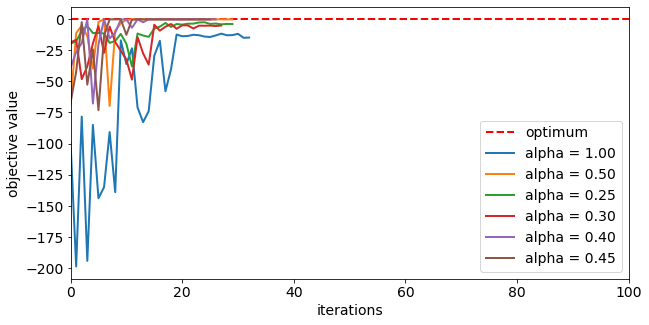

In [33]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [34]:
qaoa.ansatz.count_ops()

OrderedDict([('h', 10), ('PauliEvolution', 2)])

In [35]:
from qiskit import transpile

In [36]:
qc_basis = transpile(qaoa.ansatz, backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

In [37]:
gate_dict

OrderedDict([('cx', 90), ('u', 75)])

## Finding the circuit cost ##

### Cost is described as following in the into notebook for a maxcut problem ###
### task_price = 0.25 # price for submitting task to system (in dollars) ###

### price_per_CNOT = 0.0001 # price for a single CNOT gate (in dollars) ###
### price_per_Zrot = 0.00003 # price for a single Z rotation (in dollars) ###
### price_per_Xrot = 0.00008 # price for a single X rotation (in dollars) ###

### price_per_shot = p * (len(G.edges()) * (2* price_per_CNOT + price_per_Zrot) + len(G.nodes()) * price_per_Xrot) ###

### Optim_evals = res.nfev # Number of optimization steps i.e. the number of times the quantum hardware was called. ###
### Meas_shots = shotsin # Number of measurements of quantum hardware i.e. number of times the circuit was applied to the hardware. ###

### Cost = (Optim_evals * shotsin * price_per_shot) + task_price ###


### We decided to define our cost in a similar way below. We calculate the cost for different alpha values seperately as the number of iterations required for convergence is different for different alpha values. The default number of shots is 1024. We just set cost of a single cx gate as 0.0001and the cost of a single qubit gate as 0.00005. Task price is 0.25. ###

In [38]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 431.098
Total cost for when alpha is 0.5: 391.93
Total cost for when alpha is 0.25: 391.93
Total cost for when alpha is 0.3: 365.81800000000004
Total cost for when alpha is 0.4: 352.762
Total cost for when alpha is 0.45: 339.706


### We evaluated the cost for different alphas, but we also need to see if we are not too far away from optimal even if the cost is least for any alpha. Based on that, we could conclude which alpha works best. We can see this from the plot itself and also from the cell output where we ran QAOA, but lets print the exact optimal value here. ###

In [39]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.25553763310614386
The optimal value with alpha 0.5: -0.2548438013733403
The optimal value with alpha 0.25: -0.25678146226908893
The optimal value with alpha 0.3: -0.2548438013733403
The optimal value with alpha 0.4: -0.2548438013733403
The optimal value with alpha 0.45: -0.2548438013733403


### alpha=1 seems best due to slightly lower cost and the same optimal value as alpha 0.5 and alpha 0.25. This is because alpha=1 led to convergence much faster. ###

### Circuit depth ###

In [40]:
qc_basis.depth()

54

### Optimizer time ###

In [41]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 32.7853729724884
Optimizer time for alpha 0.5: 29.403862237930298
Optimizer time for alpha 0.25: 33.17349362373352
Optimizer time for alpha 0.3: 34.235607385635376
Optimizer time for alpha 0.4: 31.411546230316162
Optimizer time for alpha 0.45: 30.40173840522766


In [45]:
qaoa.ansatz.num_parameters

2

In [47]:
# qaoa.ansatz.draw()

## Trying different fake backends and using noise models for the same experiment ##

### The fake backends are built to mimic the behaviors of IBM Quantum systems using system snapshots. The system snapshots contain important information about the quantum system such as coupling map, basis gates, qubit properties (T1, T2, error rate, etc.) which are useful for testing the transpiler and performing noisy simulation of the system. ###

### starting with the FakeMumbai backend ###

In [78]:
import os
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeSydney, FakeMumbai
from qiskit.utils import QuantumInstance

In [79]:
device_backend = FakeMumbai()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = AerSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()
seed=1234
algorithm_globals.random_seed = 1234
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=1024)

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['x', 'measure', 'cx', 'sx', 'reset', 'id']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

In [80]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.2558995449738859
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=1.0, x_7=0.0, x_8=0.0, x_9=1.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.25553763310614386
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=0.0, x_9=1.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.2563296633540517
variable values: x_0=0.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=1.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.25553763310614386
variable values: x_0=1.0, x

### Note: With the above noise model, results seem slightly different from what we got with the qasm simulator ###

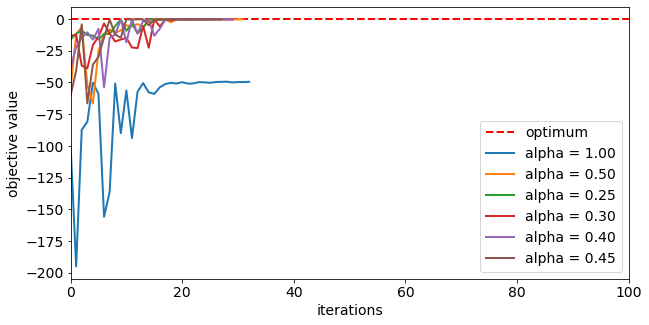

In [81]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [82]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

gate_dict

OrderedDict([('cx', 207), ('u', 105)])

In [88]:
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('The number of iterations for alpha '+str(alpha)+': '+ str(optim_evals))

The number of iterations for alpha 1.0: 33
The number of iterations for alpha 0.5: 32
The number of iterations for alpha 0.25: 26
The number of iterations for alpha 0.3: 30
The number of iterations for alpha 0.4: 30
The number of iterations for alpha 0.45: 28


In [83]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 877.1524000000001
Total cost for when alpha is 0.5: 850.5796
Total cost for when alpha is 0.25: 691.1428000000001
Total cost for when alpha is 0.3: 797.434
Total cost for when alpha is 0.4: 797.434
Total cost for when alpha is 0.45: 744.2884


In [84]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.2558995449738859
The optimal value with alpha 0.5: -0.25553763310614386
The optimal value with alpha 0.25: -0.2563296633540517
The optimal value with alpha 0.3: -0.2548438013733403
The optimal value with alpha 0.4: -0.2548438013733403
The optimal value with alpha 0.45: -0.25553763310614386


In [85]:
### Circuit depth ###

qc_basis.depth()

161

In [86]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 70.67157745361328
Optimizer time for alpha 0.5: 64.3527410030365
Optimizer time for alpha 0.25: 51.773109674453735
Optimizer time for alpha 0.3: 56.2127959728241
Optimizer time for alpha 0.4: 58.472965478897095
Optimizer time for alpha 0.45: 54.36189842224121


### We see the optimal values for different alphas are close, but the cost w.r.t alpha=0.25 is the least and much lower than costs for alpha 1.0 and alpha 0.5. So for this backend with noise, alpha 0.25 worked best. ###

### FakeWashington device backend ###

In [40]:
import os
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeWashington
from qiskit.utils import QuantumInstance

device_backend = FakeWashington()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = AerSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()
seed=1234
algorithm_globals.random_seed = 1234
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=1024)

C:\Users\Admin\anaconda3\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (260581.28986315246 > 2 * 80026.57875131005). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\Admin\anaconda3\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (115349.1827351713 > 2 * 56743.169831786116). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\Admin\anaconda3\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (260581.28986315246 > 2 * 80026.57875131005). Truncating to maximum value

C:\Users\Admin\anaconda3\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (115349.1827351713 > 2 * 56743.169831786116). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\Admin\anaconda3\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (260581.28986315246 > 2 * 80026.57875131005). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\Admin\anaconda3\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (115349.1827351713 > 2 * 56743.169831786116). Truncating to maximum value

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['x', 'measure', 'cx', 'sx', 'reset', 'id']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 

C:\Users\Admin\anaconda3\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (0.00026058128986315243 > 2 * 8.002657875131006e-05). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\Admin\anaconda3\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (0.0001153491827351713 > 2 * 5.674316983178612e-05). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"


### This backend shows a lot of warnings, but qiskit resolved it by  turncating T_2 relaxation time to the theoretically max possible value and same for all the error parameters ###

In [41]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.25553763310614386
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=0.0, x_9=1.0
status: SUCCESS

Wall time: 5min 54s


### The result is slightly different for alpha=0.25 and the time taken is significantly higher than the noiseless simulator and the FakeMumbai simulator (5 min 39s). This backend has 127 qubits vs 27 qubits that FakeMumbai has ###

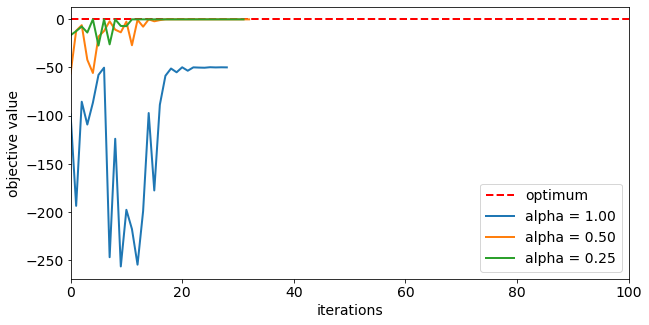

In [42]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [43]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

gate_dict

OrderedDict([('cx', 212), ('u', 105)])

In [44]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 785.7092
Total cost for when alpha is 0.5: 894.0484
Total cost for when alpha is 0.25: 866.9636


In [45]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.2548438013733403
The optimal value with alpha 0.5: -0.2548438013733403
The optimal value with alpha 0.25: -0.25553763310614386


### Clearly alpha=1.0 wins here. This is because the backend had much more noise and alpha=1.0 led to a convergence much faster. The effects of errors are clearly seen with more iterations that are required for lower alpha values ###

In [46]:
### Circuit depth ###

qc_basis.depth()

160

In [47]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 107.87299013137817
Optimizer time for alpha 0.5: 122.1123456954956
Optimizer time for alpha 0.25: 113.82375001907349


### FakeToronto device backend ###

In [48]:
import os
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeToronto
from qiskit.utils import QuantumInstance

device_backend = FakeToronto()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = AerSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()
seed=1234
algorithm_globals.random_seed = 1234
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=1024)

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['x', 'measure', 'cx', 'sx', 'reset', 'id']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

In [49]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

Wall time: 2min 27s


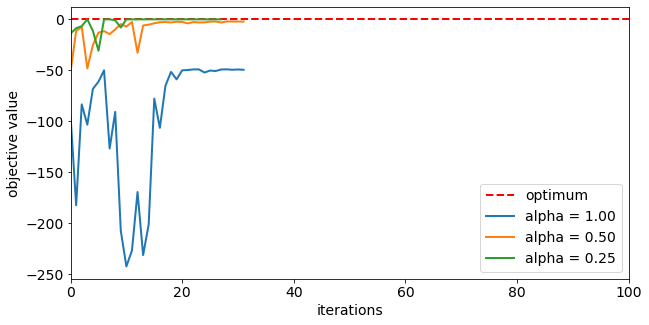

In [50]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [51]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

gate_dict

OrderedDict([('cx', 189), ('u', 141)])

In [52]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 850.5796
Total cost for when alpha is 0.5: 850.5796
Total cost for when alpha is 0.25: 744.2884


In [53]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.2548438013733403
The optimal value with alpha 0.5: -0.2548438013733403
The optimal value with alpha 0.25: -0.2548438013733403


### We get the same optimal values for all the 3 alpha values, but the cost for 0.25 alpha is clearly the least and that works best for this noisy backend. ###

In [54]:
### Circuit depth ###

qc_basis.depth()

155

In [55]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 49.005818367004395
Optimizer time for alpha 0.5: 50.72268795967102
Optimizer time for alpha 0.25: 44.04857659339905


### different optimizer ###

In [91]:
# set classical optimizer
maxiter = 100
optimizer = CG(maxiter=maxiter)

# set variational ansatz
#ansatz = RealAmplitudes(n, reps=1)
#m = ansatz.num_parameters

# # set backend

# backend_name = "qasm_simulator"  # use this for QASM simulator
# # backend_name = 'aer_simulator_statevector'  # use this for statevector simlator
# backend = Aer.get_backend(backend_name)

# # run variational optimization for different values of alpha
# alphas = [1.0, 0.50, 0.25, 0.3, 0.4, 0.45]  # confidence levels to be evaluated

In [92]:
device_backend = FakeMumbai()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = AerSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()
seed=1234
algorithm_globals.random_seed = 1234
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=1024)

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['x', 'measure', 'cx', 'sx', 'reset', 'id']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

In [93]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

### Note: With the above noise model, results seem slightly different from what we got with the qasm simulator ###

alpha = 1.0:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.25553763310614386
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=0.0, x_9=1.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.2558995449738859
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=1.0, x_7=0.0, x_8=0.0, x_9=1.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.25596729132934115
variable values: x_0=0.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.25596729132934115
variable values: x_0=0.0, 

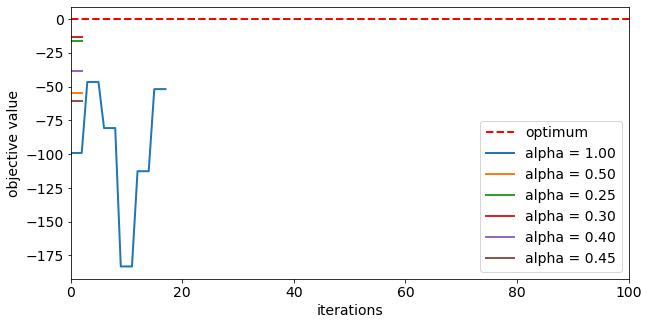

In [94]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [95]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

gate_dict

for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('The number of iterations for alpha '+str(alpha)+': '+ str(optim_evals))

The number of iterations for alpha 1.0: 18
The number of iterations for alpha 0.5: 3
The number of iterations for alpha 0.25: 3
The number of iterations for alpha 0.3: 3
The number of iterations for alpha 0.4: 3
The number of iterations for alpha 0.45: 3


In [96]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 447.226
Total cost for when alpha is 0.5: 74.74600000000001
Total cost for when alpha is 0.25: 74.74600000000001
Total cost for when alpha is 0.3: 74.74600000000001
Total cost for when alpha is 0.4: 74.74600000000001
Total cost for when alpha is 0.45: 74.74600000000001


In [97]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.2548438013733403
The optimal value with alpha 0.5: -0.25553763310614386
The optimal value with alpha 0.25: -0.2548438013733403
The optimal value with alpha 0.3: -0.2558995449738859
The optimal value with alpha 0.4: -0.25596729132934115
The optimal value with alpha 0.45: -0.25596729132934115


In [98]:
### Circuit depth ###

qc_basis.depth()

169

In [99]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 36.51720213890076
Optimizer time for alpha 0.5: 5.512085676193237
Optimizer time for alpha 0.25: 5.234857559204102
Optimizer time for alpha 0.3: 6.252118349075317
Optimizer time for alpha 0.4: 5.242650032043457
Optimizer time for alpha 0.45: 5.026722192764282


## custom initial point ##

In [48]:
import os
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeSydney, FakeMumbai
from qiskit.utils import QuantumInstance

device_backend = FakeMumbai()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = AerSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()
seed=1234
algorithm_globals.random_seed = 1234
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=1024)

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'cx', 'id', 'measure', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

In [66]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        initial_point = np.array([10.0, 10.0]),
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.2558995449738859
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=1.0, x_7=0.0, x_8=0.0, x_9=1.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1

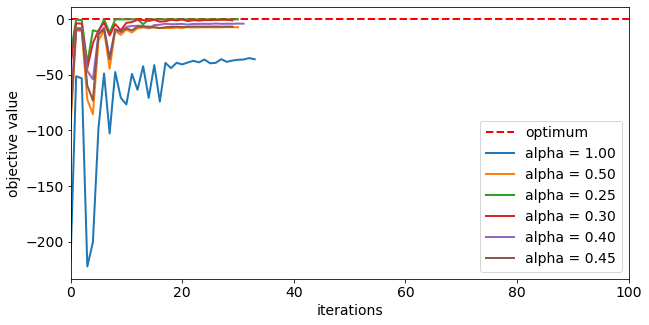

In [67]:
### Note: With the above noise model, results seem slightly different from what we got with the qasm simulator ###

# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [68]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

In [69]:
gate_dict

OrderedDict([('cx', 220), ('u', 99)])

In [70]:
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('The number of iterations for alpha '+str(alpha)+': '+ str(optim_evals))

The number of iterations for alpha 1.0: 34
The number of iterations for alpha 0.5: 31
The number of iterations for alpha 0.25: 31
The number of iterations for alpha 0.3: 30
The number of iterations for alpha 0.4: 32
The number of iterations for alpha 0.45: 30


In [71]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 938.5412000000001
Total cost for when alpha is 0.5: 855.7508
Total cost for when alpha is 0.25: 855.7508
Total cost for when alpha is 0.3: 828.154
Total cost for when alpha is 0.4: 883.3476
Total cost for when alpha is 0.45: 828.154


In [72]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.2558995449738859
The optimal value with alpha 0.5: -0.2548438013733403
The optimal value with alpha 0.25: -0.2548438013733403
The optimal value with alpha 0.3: -0.2548438013733403
The optimal value with alpha 0.4: -0.2548438013733403
The optimal value with alpha 0.45: -0.2548438013733403


In [73]:
### Circuit depth ###

qc_basis.depth()

175

In [74]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 60.926618576049805
Optimizer time for alpha 0.5: 55.75375723838806
Optimizer time for alpha 0.25: 55.43870425224304
Optimizer time for alpha 0.3: 57.74258303642273
Optimizer time for alpha 0.4: 58.06706261634827
Optimizer time for alpha 0.45: 56.36040925979614


### new initial point ###

In [58]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        initial_point = np.array([0.001, 0.001]),
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

alpha = 1.0:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.2558995449738859
variable values: x_0=1.0, x_1

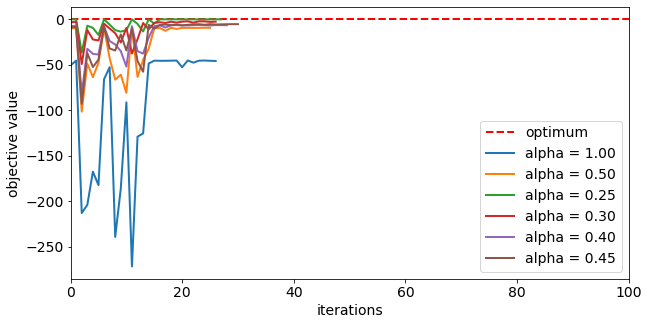

In [59]:
### Note: With the above noise model, results seem slightly different from what we got with the qasm simulator ###

# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [60]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

gate_dict

OrderedDict([('cx', 204), ('u', 111)])

In [61]:
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('The number of iterations for alpha '+str(alpha)+': '+ str(optim_evals))

The number of iterations for alpha 1.0: 27
The number of iterations for alpha 0.5: 26
The number of iterations for alpha 0.25: 28
The number of iterations for alpha 0.3: 27
The number of iterations for alpha 0.4: 29
The number of iterations for alpha 0.45: 31


In [62]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 717.7156
Total cost for when alpha is 0.5: 691.1428000000001
Total cost for when alpha is 0.25: 744.2884
Total cost for when alpha is 0.3: 717.7156
Total cost for when alpha is 0.4: 770.8612
Total cost for when alpha is 0.45: 824.0068


In [63]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.2548438013733403
The optimal value with alpha 0.5: -0.2548438013733403
The optimal value with alpha 0.25: -0.2548438013733403
The optimal value with alpha 0.3: -0.2548438013733403
The optimal value with alpha 0.4: -0.2548438013733403
The optimal value with alpha 0.45: -0.2558995449738859


In [64]:
### Circuit depth ###

qc_basis.depth()

158

In [65]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 49.086315631866455
Optimizer time for alpha 0.5: 47.8271861076355
Optimizer time for alpha 0.25: 50.278504610061646
Optimizer time for alpha 0.3: 48.86986231803894
Optimizer time for alpha 0.4: 52.74457669258118
Optimizer time for alpha 0.45: 56.13037109375


### third initial point ###

In [75]:
%%time
# dictionaries to store optimization progress and results
objectives = {alpha: [] for alpha in alphas}  # set of tested objective functions w.r.t. alpha
results = {}  # results of minimum eigensolver w.r.t alpha

# callback to store intermediate results
def callback(i, params, obj, stddev, alpha):
    # we translate the objective from the internal Ising representation
    # to the original optimization problem
    objectives[alpha] += [-(obj + offset)]


# loop over all given alpha values
for alpha in alphas:

    # initialize CVaR_alpha objective
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
#     cvar_exp.compute_variance = lambda x: [0]  # to be fixed in PR #1373

    # initialize VQE using CVaR
    qaoa = QAOA(
        initial_point = np.array([1.0, 2.0]),
        expectation=cvar_exp,
        optimizer=optimizer,
        quantum_instance=qi,
        callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha),
    )

    # initialize optimization algorithm based on CVaR-VQE
    opt_alg = MinimumEigenOptimizer(qaoa)

    # solve problem
    results[alpha] = opt_alg.solve(qp)

    # print results
    print("alpha = {}:".format(alpha))
    print(results[alpha].prettyprint())
    print()

### Note: With the above noise model, results seem slightly different from what we got with the qasm simulator ###

alpha = 1.0:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.5:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.25:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.3:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.4:
objective function value: -0.2548438013733403
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS

alpha = 0.45:
objective function value: -0.25553763310614386
variable values: x_0=1.0, x_

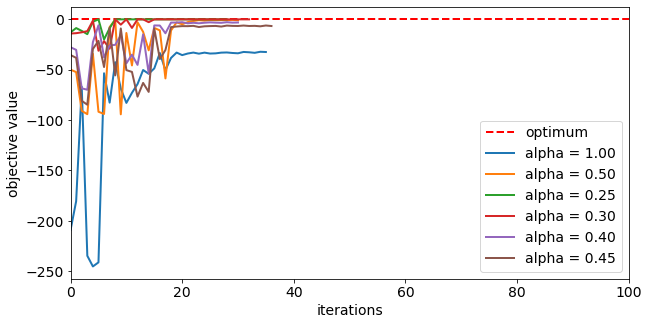

In [76]:
# plot resulting history of objective values
plt.figure(figsize=(10, 5))
plt.plot([0, maxiter], [opt_result.fval, opt_result.fval], "r--", linewidth=2, label="optimum")
for alpha in alphas:
    plt.plot(objectives[alpha], label="alpha = %.2f" % alpha, linewidth=2)
plt.legend(loc="lower right", fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel("iterations", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("objective value", fontsize=14)
plt.show()

In [77]:
qc_basis = transpile(qaoa.ansatz, device_backend,optimization_level=3, basis_gates=['cx','u'])
# qc_basis.draw()
gate_dict=qc_basis.count_ops()

gate_dict

OrderedDict([('cx', 182), ('u', 111)])

In [78]:
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('The number of iterations for alpha '+str(alpha)+': '+ str(optim_evals))

The number of iterations for alpha 1.0: 36
The number of iterations for alpha 0.5: 31
The number of iterations for alpha 0.25: 29
The number of iterations for alpha 0.3: 33
The number of iterations for alpha 0.4: 31
The number of iterations for alpha 0.45: 37


In [79]:
task_price=0.25
cost_cx = 0.0001
cost_u = 0.00005
price_per_shot = (cost_cx * gate_dict.get('cx')) + (cost_u * gate_dict.get('u'))
shotsin=1024
for alpha in alphas:
    optim_evals=len(objectives[alpha])
    print('Total cost for when alpha is '+str(alpha)+': '+ str((optim_evals*shotsin*price_per_shot)+task_price))
# total_cost = (optim_evals*shotsin*price_per_shot)+task_price

Total cost for when alpha is 1.0: 875.77
Total cost for when alpha is 0.5: 754.17
Total cost for when alpha is 0.25: 705.53
Total cost for when alpha is 0.3: 802.8100000000001
Total cost for when alpha is 0.4: 754.17
Total cost for when alpha is 0.45: 900.09


In [80]:
for alpha in alphas:
    print('The optimal value with alpha '+str(alpha)+': '+str(results[alpha].fval))

The optimal value with alpha 1.0: -0.2548438013733403
The optimal value with alpha 0.5: -0.2548438013733403
The optimal value with alpha 0.25: -0.2548438013733403
The optimal value with alpha 0.3: -0.2548438013733403
The optimal value with alpha 0.4: -0.2548438013733403
The optimal value with alpha 0.45: -0.25553763310614386


In [81]:
### Circuit depth ###

qc_basis.depth()

141

In [82]:
for alpha in alphas:
    x=results[alpha]
    print('Optimizer time for alpha '+ str(alpha)+ ': '+ str(x.min_eigen_solver_result.optimizer_time))

Optimizer time for alpha 1.0: 68.31823396682739
Optimizer time for alpha 0.5: 54.18085217475891
Optimizer time for alpha 0.25: 51.123921155929565
Optimizer time for alpha 0.3: 59.61173105239868
Optimizer time for alpha 0.4: 52.87729573249817
Optimizer time for alpha 0.45: 65.43023180961609


### for our use case, choosing smaller parameters values in the initial point gave best results in terms of cost ###